In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2

In [113]:
path = 'minimal_pkls/'
save_path = 'phi_stats/'
os.makedirs(save_path, exist_ok=True)
files = os.listdir(path)
len(files)

201

In [193]:
from social_phi import get_signal, experiment_hop_range

def flatten(l : list):
    return [item for sublist in l for item in sublist]

def run_experiment(file, time_scale=24*3600, window=30):
    if os.path.exists(save_path + file[:-4] + '.csv'):
        return
    
    data = pickle.load(open(path + file, 'rb'))
    sig = get_signal(data['activities'], time_scale=time_scale, binarize=True)
    stats = experiment_hop_range(sig=sig, window=window, min_hop=1, max_hop=window, silent=True)
    stats.to_csv(save_path + file[:-4] + '.csv', index=False)
    
    
def load_data(file):
    stats = pd.read_csv(save_path + file[:-4].replace('____', '-') + '.csv')
    data = pickle.load(open(path + file, 'rb'))
    act = flatten(data['activities'].values())
    
    res = {
#         'file' : file[:-4],
        'forks' : data['forks'],
        'stars' : data['stars'],
        'open_issues' : np.sum(data['issues_state']),
        'closed_issues' : len(data['issues_state']) - np.sum(data['issues_state']),
        'avg_issue_survival' : np.mean(data['issues_lifetime']),
        'users' : len(data['activities']),
        'total_commits' : len(act),
        'timeline_length' : (max(act) - min(act)) // (24*3600),
        'avg_phi' : stats.loc[np.argmax(stats['avg_phi'])].avg_phi
    }
    res['avg_commit_per_day'] = res['total_commits'] / res['timeline_length']
    res['avg_commit_per_user'] = res['total_commits'] / res['users']
    res['closed_open_ratio'] = res['closed_issues'] / res['open_issues'] if res['open_issues'] > 0 else 0.
    return res

In [162]:
# from joblib import Parallel, delayed

# _ = Parallel(n_jobs=20)(delayed(run_experiment)(file) for file in tqdm(files))

In [256]:
df = pd.DataFrame(
    columns=['forks', 'stars', 'users', 
             'total_commits', 'timeline_length','avg_commit_per_day', 'avg_commit_per_user',
             'open_issues', 'closed_issues', 'avg_issue_survival',
             'closed_open_ratio', 'avg_phi'])
for file in os.listdir(path):
    df = df.append(load_data(file), ignore_index=True)
df = df.astype(float)
print(df.shape)
df.describe()

(200, 12)


,forks,stars,users,total_commits,timeline_length,avg_commit_per_day,avg_commit_per_user,open_issues,closed_issues,avg_issue_survival,closed_open_ratio,avg_phi
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,7310.725000,34761.095000,626.325000,10420.275000,2897.120000,4.331872,32.828833,751.060000,10413.280000,114.900067,51.996595,1.290023
std,8987.707573,32779.152061,837.297933,5509.547699,1182.043621,4.569576,57.893841,975.378657,9018.750499,112.082470,103.090327,0.271881
min,719.000000,15237.000000,11.000000,1520.000000,414.000000,0.588235,2.455188,0.000000,504.000000,3.163547,0.000000,0.806184
25%,2934.000000,18782.000000,247.000000,6215.250000,2127.000000,2.172131,13.526999,158.750000,4820.500000,39.846452,8.696730,1.110893
50%,4426.500000,24287.500000,455.500000,8448.000000,2737.000000,3.423221,21.496770,502.500000,8334.500000,81.723641,17.018014,1.239973
75%,7774.500000,37941.500000,714.500000,13560.750000,3599.250000,5.186717,33.734695,913.750000,12588.500000,146.399293,42.927632,1.408420
max,73734.000000,325401.000000,9618.000000,27770.000000,7847.000000,57.038647,586.708333,9239.000000,75807.000000,643.970195,650.058824,2.678072


## issue survival analysis

In [221]:
# all_issues_lifetime = []
# for file in os.listdir(path):
#     if '____' in file:
#         data = pickle.load(open(path + file, 'rb'))
#         all_issues_lifetime += [data['issues_lifetime']]

# m = min(flatten(all_issues_lifetime))
# M = max(flatten(all_issues_lifetime))
# n_bins = 1000
# issue_bins = np.linspace(m, M + 1, n_bins + 1)
# issues_survival = np.array([np.histogram(lifetime, issue_bins)[0] for lifetime in all_issues_lifetime])
# mean_issues_survival = np.array([np.mean(lifetime) for lifetime in all_issues_lifetime])

# scale = MinMaxScaler()
# # #StandardScaler()

# pca = PCA(n_components=1).fit(issues_survival)
# # cum_var = np.cumsum(pca.explained_variance_ratio_)
# issue_life_comps = pca.transform(issues_survival)
# # print(cum_var[-1])

# # plt.figure(figsize=(20,5))
# # plt.subplot(1,2,1)
# # plt.title('pc1')
# scaled_comps = scale.fit_transform(issue_life_comps)
# # plt.hist(scaled_comps, 100)

# # plt.subplot(1,2,2)
# # plt.title('mean')
# scaled_means = scale.fit_transform(mean_issues_survival.reshape(-1,1))
# # plt.hist(scaled_means, 100)
# # print('means var:',np.var(scaled_means), ' comps var:', np.var(scaled_comps))
# # # plt.scatter(issue_life_comps[:,0], issue_life_comps[:,1])
# # plt.show()

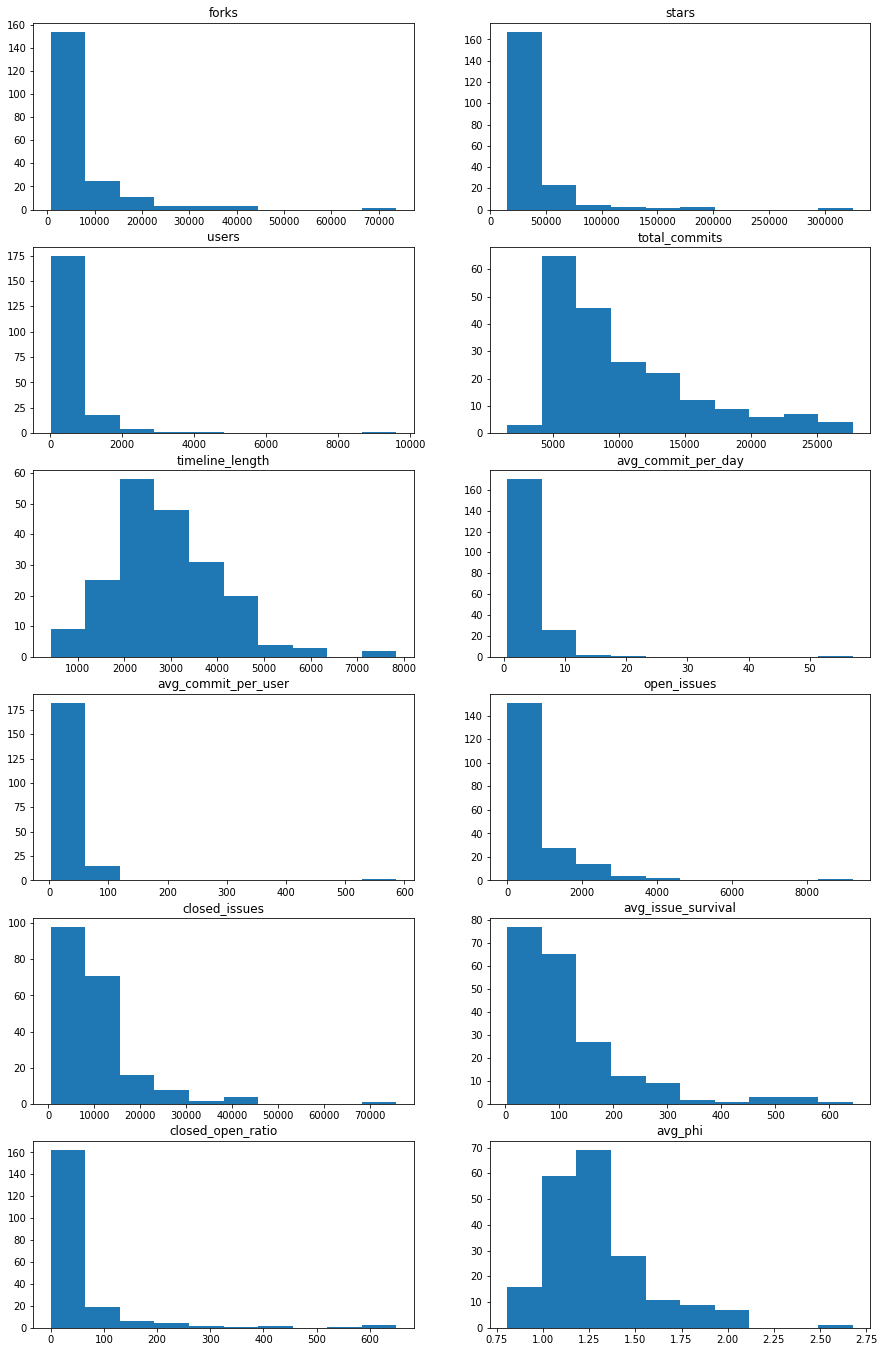

In [243]:
bins = 10
n = len(df.columns)

plt.figure(figsize=(15,n*2))
for i,col in enumerate(df.columns):
    plt.subplot(int(np.round(n/2)), 2, i+1)
    plt.title(col)
    plt.hist(df[col], bins)

plt.show()

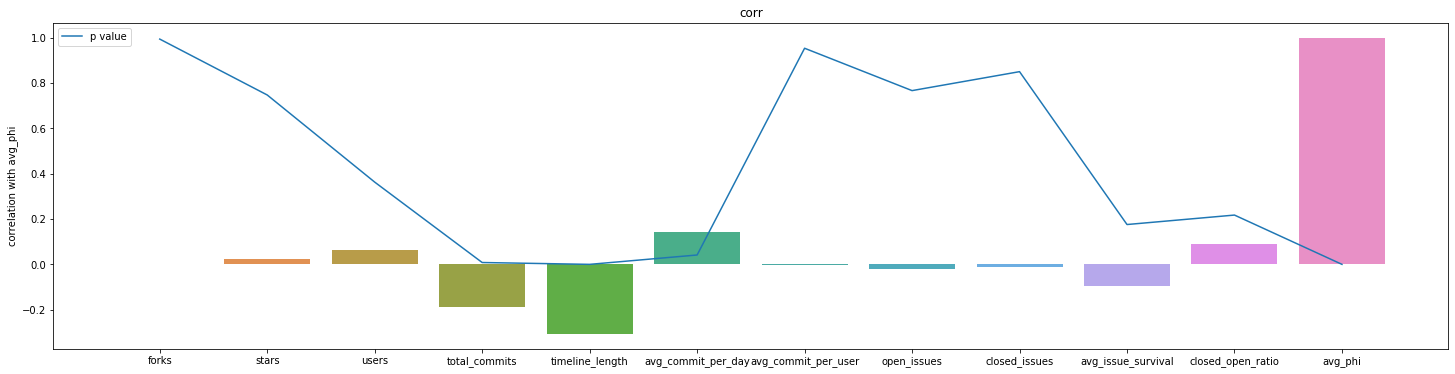

In [249]:
from scipy import stats as sci_stats
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score


corrs = df.corr(method='pearson') # spearman , kendall
corr_tvals = corrs * np.sqrt(df.shape[0] - 2) / np.sqrt(1 - corrs**2)
corr_pvals = sci_stats.t.sf(np.abs(corr_tvals), df.shape[0] - 2)*2
corr_pvals = pd.DataFrame(corr_pvals, columns=df.columns, index=df.columns)

plt.figure(figsize=(25,6))
plt.title('corr')
sns.barplot(y=corrs['avg_phi'], x=df.columns)
plt.plot(corr_pvals['avg_phi'], label='p value')
plt.ylabel('correlation with avg_phi')
plt.legend()
plt.show()

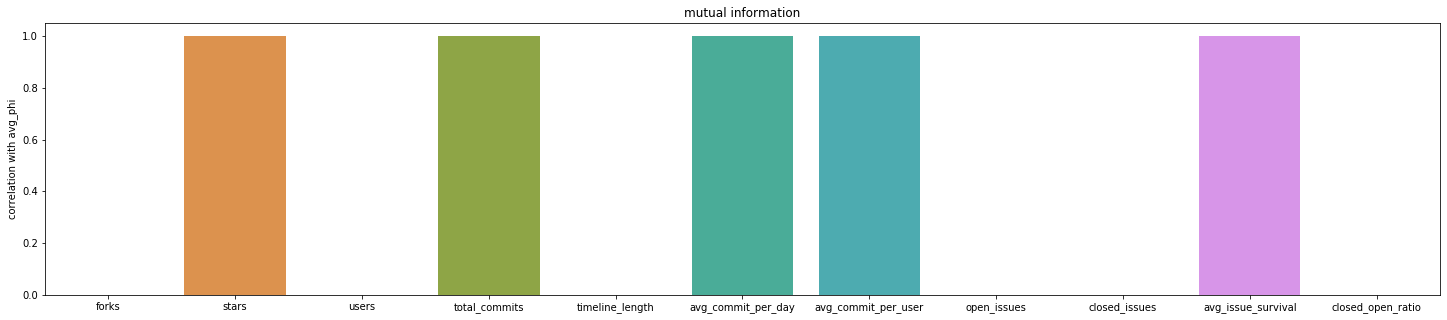

In [252]:
mis = np.zeros(shape=df.shape[1]-1)
for i,col in enumerate(df.drop(['avg_phi'], axis=1).columns):
    mis[i] = adjusted_mutual_info_score(df.avg_phi, df[col])

plt.figure(figsize=(25,5))
plt.title('mutual information')
sns.barplot(y=mis, x=df.drop(['avg_phi'], axis=1).columns)
plt.ylabel('correlation with avg_phi')
plt.show()

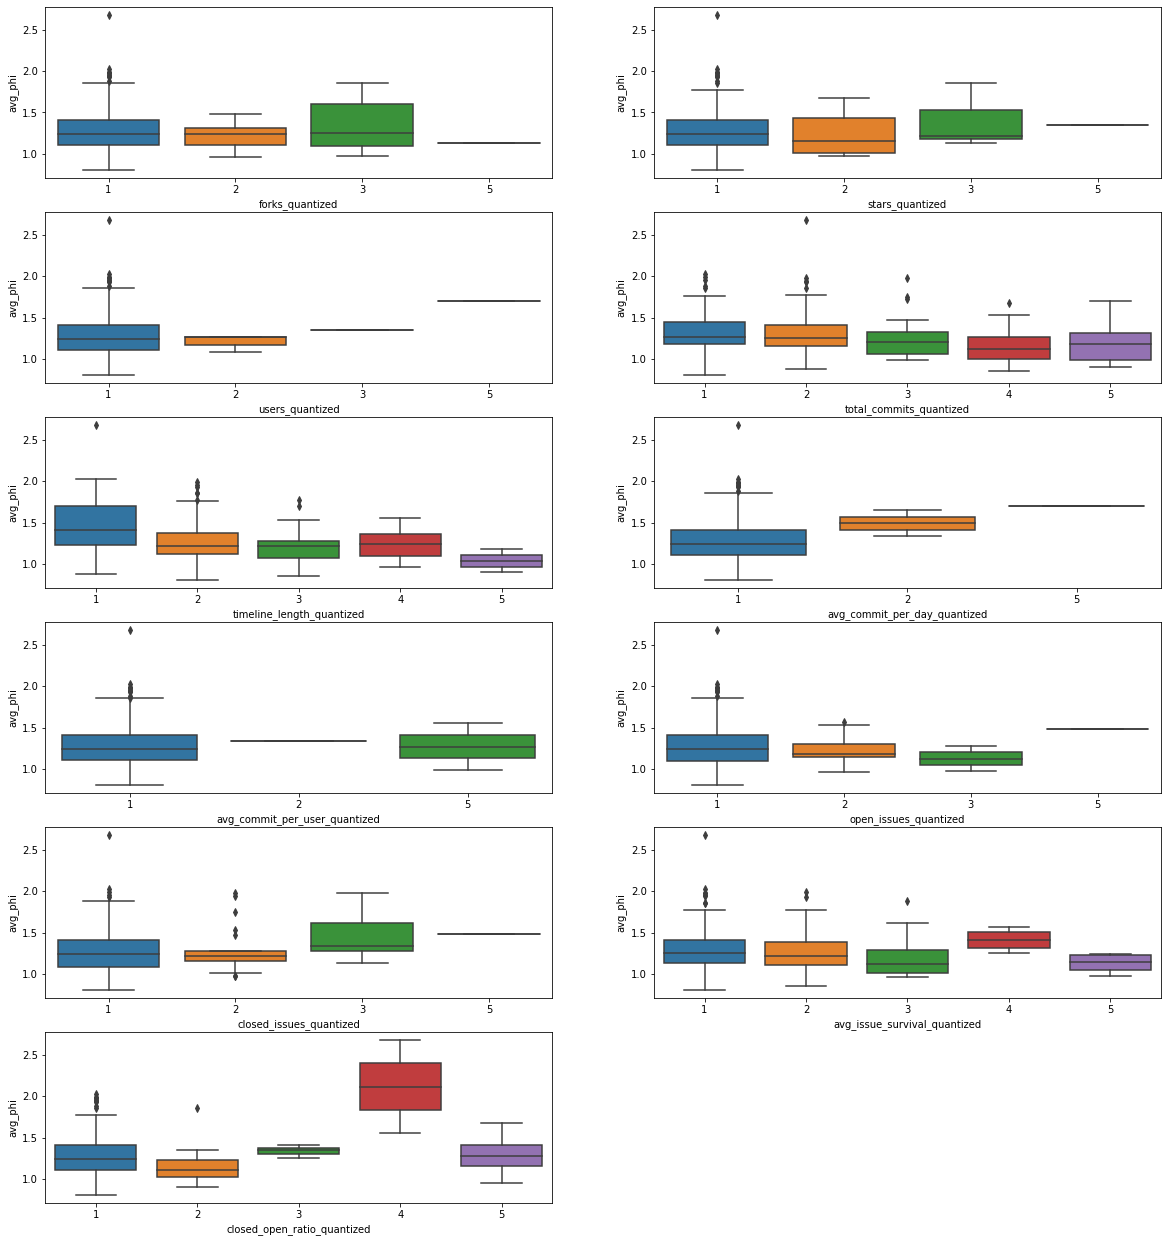

In [253]:
def quantize_col(data, col, n_bins=5):
    bins = np.linspace(np.min(data[col]), np.max(data[col])+1, n_bins+1)
    temp_df = data.copy()[[col, 'avg_phi']]
    temp_df[col+'_quantized'] = np.digitize(temp_df[col], bins=bins)   
    sns.boxplot(data=temp_df, x=col+'_quantized', y='avg_phi')

n = len(df.columns) - 1
plt.figure(figsize=(20,n*2))
for i,col in enumerate(df.drop(['avg_phi'], axis=1).columns):
    plt.subplot(n // 2 +1, 2, i+1)
    quantize_col(df, col, n_bins=5)
plt.show()

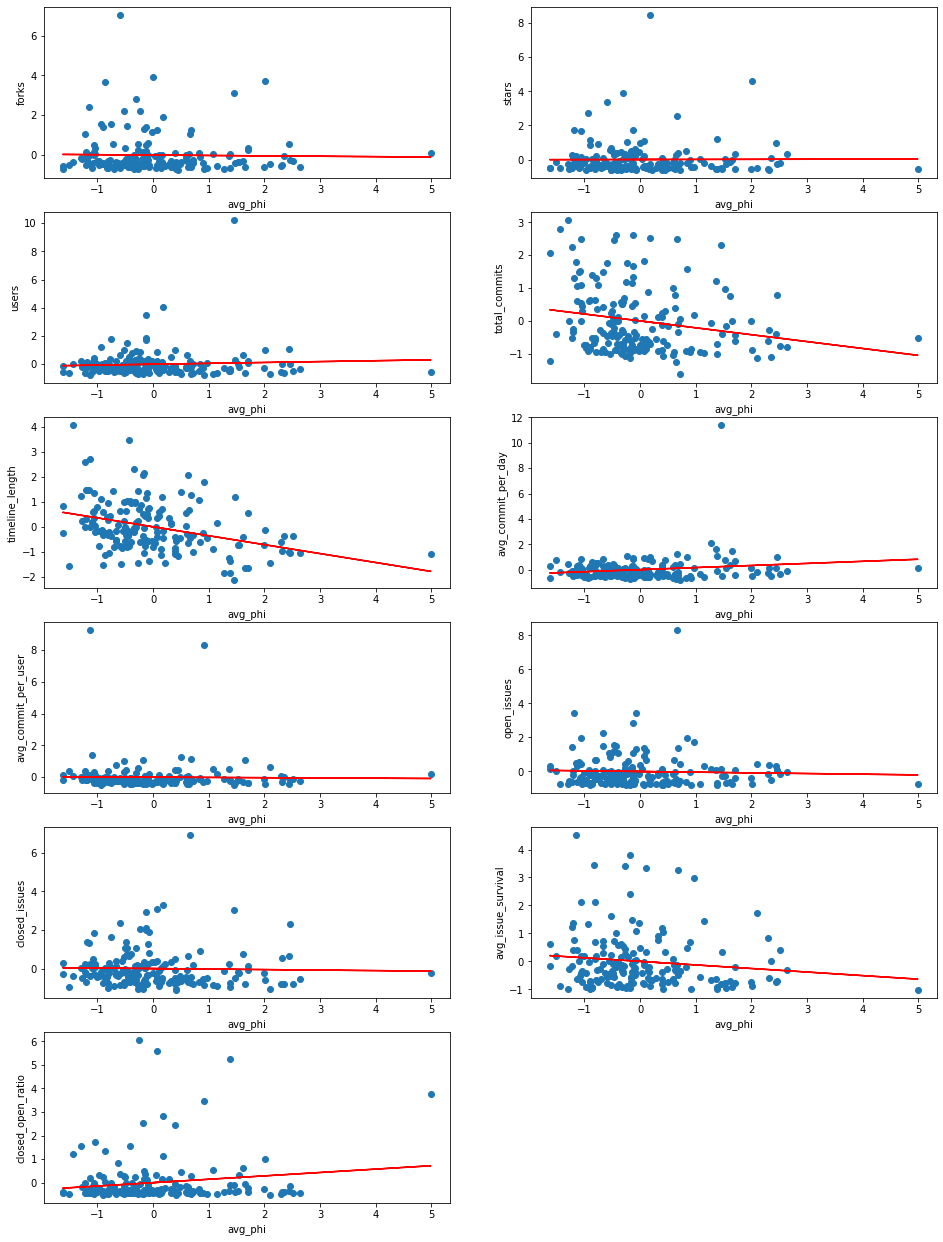

In [203]:
n = len(df.columns) - 1
standardize = lambda v : (v - v.mean()) / v.std()
x = standardize(df['avg_phi'].values)

plt.figure(figsize=(16,n*2))
for i,col in enumerate(df.drop(['avg_phi'], axis=1).columns):
    y = standardize(df[col].values)
    lr = LinearRegression().fit(x.reshape(-1,1),y)
    
    plt.subplot(n // 2 + 1, 2, i+1)
    plt.xlabel('avg_phi')
    plt.ylabel(col)
    plt.scatter(x=x, y=y)
    plt.plot(x, lr.predict(x.reshape(-1,1)), c='r')
    
plt.show()

In [204]:
def experiment_regression(data, keys : list, plot=True):
    scale = StandardScaler()
    X_res = data.drop(['avg_phi'] + keys, axis=1).values
    X = data.drop(['avg_phi'], axis=1).values
    X = scale.fit_transform(X)
    X_res = scale.fit_transform(X_res)
    y = data['avg_phi'].values

    lr_res = SVR()
    lr = SVR()
    lr.fit(X, y)
    lr_res.fit(X_res, y)

    r2 = lr.score(X, y)
    r2_res = lr_res.score(X_res, y)
#     LRT = 2 * (np.log(r2) - np.log(r2_dropped))
#     p_value = chi2.sf(LRT, 1)
#     print('p value:', p_value)

    if plot:
        pred = lr.predict(X)
        pred_res = lr_res.predict(X_res)

        plt.figure(figsize=(20,10))
        plt.subplot(2,1,1)
        plt.title('full model')
        plt.plot(y)
        plt.plot(pred)

        plt.subplot(2,1,2)
        plt.title('restricted model')
        plt.plot(y)
        plt.plot(pred_res)
        plt.show()
    return r2, r2_res

In [205]:
df.columns

Index(['forks', 'stars', 'users', 'total_commits', 'timeline_length',
       'avg_commit_per_day', 'avg_commit_per_user', 'open_issues',
       'closed_issues', 'avg_issue_survival', 'closed_open_ratio', 'avg_phi'],
      dtype='object')

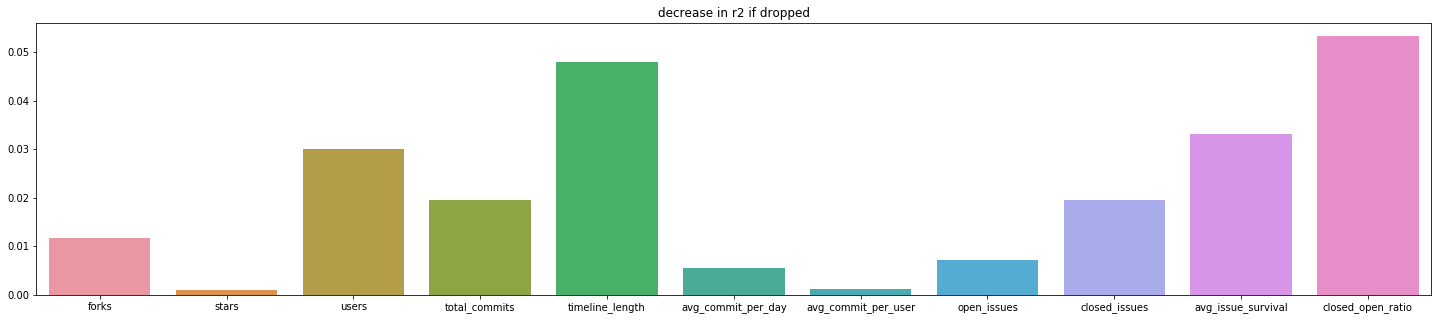

In [206]:
r2_diffs = []
for col in df.drop(['avg_phi'], axis=1).columns:
    r2, r2_res = experiment_regression(df, keys=[col], plot=False)
    r2_diffs += [r2-r2_res]

plt.figure(figsize=(25,5))
plt.title('decrease in r2 if dropped')
sns.barplot(x=df.drop(['avg_phi'], axis=1).columns, y=r2_diffs)